In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

/home/skk8kc/.conda/envs/DS6050/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing

In [2]:
# Load in the data
fake_news = pd.read_csv('data/a2_Fake.csv')
true_news = pd.read_csv('data/a1_True.csv')

# Add labels to each dataframe where 1 is fake and 0 is true
fake_news['label'] = 1
true_news['label'] = 0

# Concatenate the two dataframes
news = pd.concat([fake_news, true_news], axis=0)

In [3]:
# Split the data into training, validation, and testing sets
train_df, temp_df = train_test_split(news, test_size=0.3, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [15]:
class FakeNewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.inputs = dataframe['title']
        self.labels = dataframe['label']
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        input_text = self.inputs.iloc[idx]
        encoding = self.tokenizer(
            input_text,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        label = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # shape: [max_length]
            'label': label
        }

In [16]:
train_dataset = FakeNewsDataset(train_df, tokenizer, 64)
val_dataset = FakeNewsDataset(val_df, tokenizer, 64)
test_dataset = FakeNewsDataset(test_df, tokenizer, 64)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model Arcitecture

In [18]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.2, bidirectional=True)
        self.batchnorm = nn.BatchNorm1d(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded) # Don't need to save the final hidden states from the LSTM block
        lstm_out = self.batchnorm(lstm_out.permute(0, 2, 1)).permute(0, 2, 1)
        out = self.fc(lstm_out[:, -1, :])
        return out

## Train and Test Loops

In [19]:
def trainloop(dataloader, model, loss_func, optimizer):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_batches = len(dataloader)
    train_loss, train_acc = 0. , 0.
    model.train()
    for batch in dataloader:
        inputs = batch['input_ids']
        labels = batch['label']
        inputs = inputs.squeeze(1).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (outputs.argmax(dim=1) == labels).sum().item()
    return train_loss / num_batches, train_acc / len(dataloader.dataset)
    

def testloop(dataloader, model, loss_func):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_batches = len(dataloader)
    test_loss, test_acc = 0. , 0.
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['input_ids']
            labels = batch['label']
            inputs = inputs.squeeze(1).to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = loss_func(outputs, labels)

            test_loss += loss.item()
            test_acc += (outputs.argmax(dim=1) == labels).sum().item()
    return test_loss / num_batches, test_acc / len(dataloader.dataset)

In [26]:
# Hyperparameters
lr = 1e-4
batch_size = 32
epochs = 25
max_len = 64

In [27]:
model = LSTM(vocab_size=tokenizer.vocab_size, embedding_dim=128, hidden_dim=64, output_dim=2)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

model.to('cuda' if torch.cuda.is_available() else 'cpu')

LSTM(
  (embedding): Embedding(30522, 128)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [28]:
# Initialize lists before training
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

np.random.seed(42)

for epoch in range(epochs):
    print(f"---Epoch {epoch+1}/{epochs}:---")
    
    train_loss, train_acc = trainloop(train_loader, model, loss_func, optimizer)
    val_loss, val_acc = testloop(val_loader, model, loss_func)

    # Store results
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print progress
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}.')
    print(f'Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}.')

---Epoch 1/25:---
Train Loss: 0.6976, Train Acc: 0.5152.
Validation Loss: 0.6935, Validation Acc: 0.4733.
---Epoch 2/25:---
Train Loss: 0.4585, Train Acc: 0.7398.
Validation Loss: 0.2538, Validation Acc: 0.9066.
---Epoch 3/25:---
Train Loss: 0.1505, Train Acc: 0.9434.
Validation Loss: 0.1434, Validation Acc: 0.9483.
---Epoch 4/25:---
Train Loss: 0.1034, Train Acc: 0.9623.
Validation Loss: 0.1163, Validation Acc: 0.9563.
---Epoch 5/25:---
Train Loss: 0.0803, Train Acc: 0.9718.
Validation Loss: 0.1107, Validation Acc: 0.9596.
---Epoch 6/25:---
Train Loss: 0.0653, Train Acc: 0.9778.
Validation Loss: 0.0985, Validation Acc: 0.9636.
---Epoch 7/25:---
Train Loss: 0.0517, Train Acc: 0.9830.
Validation Loss: 0.1009, Validation Acc: 0.9663.
---Epoch 8/25:---
Train Loss: 0.0415, Train Acc: 0.9869.
Validation Loss: 0.1105, Validation Acc: 0.9648.
---Epoch 9/25:---
Train Loss: 0.0332, Train Acc: 0.9901.
Validation Loss: 0.1092, Validation Acc: 0.9660.
---Epoch 10/25:---
Train Loss: 0.0254, Train A

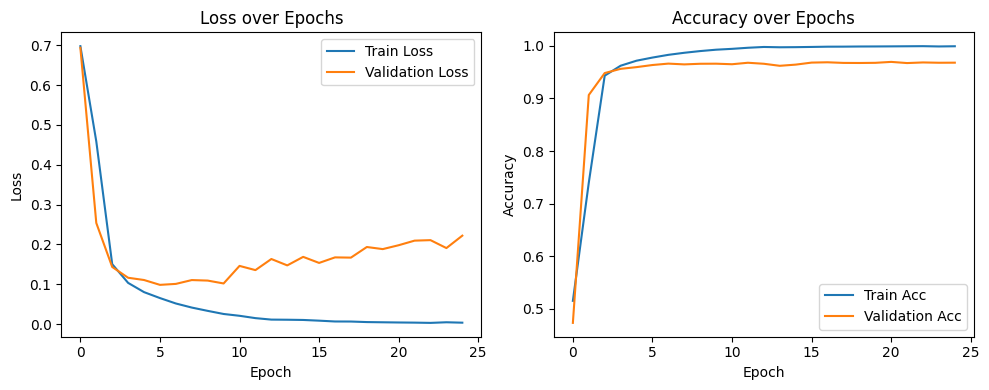

In [30]:
# Plotting loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


We see overfitting when increasing the trainig Epochs. This is not surprising as LSTM blocks are prone to overfitting. Even with adding dropouts in the LSTM block we see overfitting at about the 10th epoch of training.

In [29]:
test_loss, test_acc = testloop(test_loader, model, loss_func)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

Test Loss: 0.18711615467820758, Test Accuracy: 0.9707498144023756


In [24]:
torch.save(model.state_dict(), "./model_parameters/LSTM_bidirectional.pth")